# Part A: Notes regarding FFTLog inclusion into SciPy



### ToDo's

**Replace `cdgamma` with `scipy.special.loggamma`**
(I am lacking the necessary knowledge to do this)  
=> all calls `cdgamma(x, 1)` in `fftlog.f` can be replaced with `loggamma(x)`.

See discussion here and in the whole thread in general:
https://mail.scipy.org/pipermail/scipy-dev/2016-October/021584.html

### Notes

- `fftlog` has not, as other implemented FFT routines, any of the following
  implementations:
    - type-specific versions (output is always a float64/complex128)
    - axis-check and similar (arguments `axis`, `n`, `overwrite_x`, `howmany`
      for instance in `fft` or `rfft`.)
- Cache `fftl_w` in `src/fftlog.c` is exactly the same as cache `drfft` in
  `src/drfft.c`, and could potentially be combined.
- I never used the inverse fftlog, and never got it to work.



### Changes to `fftlog.f`

Adjusted for inclusion, all changes are marked with `%DW`
- `drfft*` -> `dfft*`
- `kr`: remove `kropt` from `fhti` (see `getkr`)
  - `kr` has to be defined exactly before calling `fhti`
  - remove parameters : `kropt`, `ok`, `lnblnk`, `stblnk`, `go`, `temp`
  - remove function   : `stblnk(string)`
- `krgood`: change from `function krgood` to `subroutine getkr`
- split `wsave` into `wsave` and `xsave`
  - `wsave` is as in regular FFT
  - `xsave` is the fftlog-addition to `wsave`
  - moved `dffti` from `fhti` to `fhtq`


### Dummy code

    function fhti:                                # Initializing routine:
        calc.                                     #
        call irfft  <= irfft from dfftpack        # Appends more stuff to
        calc.                                     # wsave from irfft

    function fftl:                                # Fast Fourier Transform
        calc.
        call fhtq -|
        calc.      |
                   |
    function fht:  |                              # Fast Hankel Transform
        calc.      |
        call fhtq -|
        calc.      |
               /---/
               |
               v
    function fhtq:                                # Core routine
        call rfftf  <= rfftf from dfftpack
        calc.
        call rfftb  <= rfftb from dfftpack



# Part B: FFTLog examples

Examples of the usage of FFTLog.

## 1. Theoretical sine and cosine transform pairs.

Reference: P. Yip, Sine and Cosine Transforms, in Transforms and Applications Handbook, Second Edition, 2000, Ed. Alexander D. Poularikas.
<https://www.crcpress.com/The-Transforms-and-Applications-Handbook-Second-Edition/Poularikas/p/book/9780849385957>

**Note:**
The transform-pairs are slightly different defined in the above reference than in FFTLog. The frequency-statements have therefore to be divided by $\sqrt{\pi/2}$.

### Imports, plot settings

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt

# I import fftpack after compiling just the fftpack within scipy:
# /path/to/scipy/scipy/fftpack> python setup.py install
import fftpack

# Style adjustments
%matplotlib inline
plt.style.use('ggplot')
rcParams['text.usetex'] = True
rcParams['font.serif'] = 'Computer Modern Roman'
rcParams['font.family'] = 'serif'
rcParams['font.style'] = 'normal'

### Plot function

In [2]:
def printfig(w, fw, t, ft, fftl, title, direction=1):
    fig = plt.figure(figsize=(10,8))
    plt.subplots_adjust(wspace=.3, hspace=.3)
    plt.suptitle(title, y=1.01, fontsize=18)

    # Plot theoretical frequency domain curve
    plt.subplot(221)
    plt.title(r'Frequency domain')
    plt.xlabel('Angular frequency $\omega$ (Hz)')
    plt.ylabel(r'Amplitude')
    plt.semilogx(w, fw, 'k-')
    if direction == -1:
        plt.plot(w, fftl, 'r-', label='FFTLog')
    plt.xlim([w.min(), w.max()])

    # Plot theoretical time domain curve and result from FFTLog
    plt.subplot(222)
    plt.title(r'Time domain')
    plt.xlabel('Time $t$ (s)')
    plt.ylabel(r'Amplitude')
    plt.loglog(t, ft, 'k-', label='Analytical')
    if direction == 1:
        plt.plot(t, fftl, 'r-', label='FFTLog')
    plt.xlim([t.min(), t.max()])
    plt.legend(loc='best')

    # Plot the absolute error
    plt.subplot(223)
    plt.title('Absolute error')
    plt.ylabel('Absolute error')
    if direction == 1:
        plt.xlabel('Time $t$ (s)')
        plt.loglog(t, abs(fftl-ft), 'r-')
        plt.xlim([t.min(), t.max()])
    else:
        plt.xlabel('Angular frequency $\omega$ (Hz)')
        plt.loglog(t, abs(fftl-fw), 'r-')
        plt.xlim([w.min(), w.max()])

    # Plot the relative error
    plt.subplot(224)
    plt.title('Relative error')
    plt.ylabel('Relative error (-)')
    if direction == 1:
        plt.xlabel('Time $t$ (s)')
        plt.loglog(t, abs(fftl-ft)/ft, 'r-')
        plt.xlim([t.min(), t.max()])
    else:
        plt.xlabel('Angular frequency $\omega$ (Hz)')
        plt.loglog(t, abs(fftl-fw)/fw, 'r-')
        plt.xlim([w.min(), w.max()])

    plt.show()

### 1.1 Sine examples

#### 1.1.1 $\qquad \sqrt{\frac{\pi}{8}}\exp(-\omega)\sin(\omega) \Longleftrightarrow \frac{t}{4 + t^4}$

True


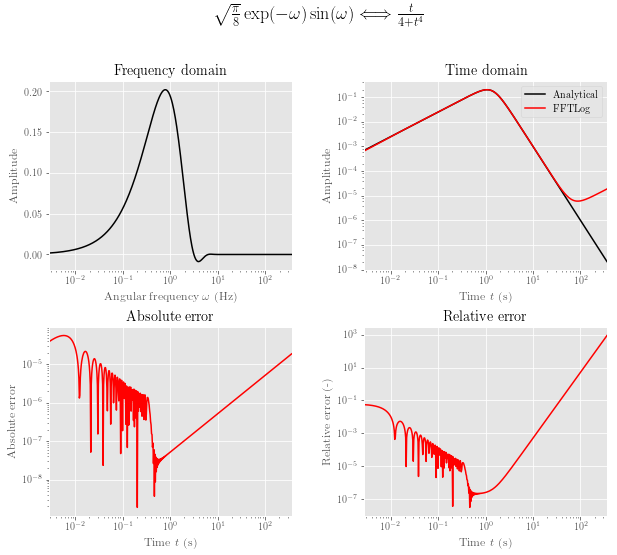

In [3]:
# FFTLog parameters
n, spacing, center = 512, .01, 0
bias = -.2
transform = 'sine'
w, t, kr, rk = fftpack.fftlogargs(n,spacing, center, transform, bias, kr=1, kropt=True)

# Analytical solution
fw = np.sqrt(np.pi/2)/2*np.exp(-w)*np.sin(w)  # Frequency domain
ft = t/(4 + t**4)                             # Time domain
title = r'$\sqrt{\frac{\pi}{8}}\exp(-\omega)\sin(\omega) \Longleftrightarrow \frac{t}{4 + t^4}$'

# FFTLog
fftl = fftpack.fftlog(fw, spacing, transform, bias, kr, rk)

print(np.all(np.isclose(fftl[120:-150], ft[120:-150], rtol=1e-3)))

# Print result
printfig(w, fw, t, ft, fftl, title)

#### 1.1.2 $\qquad \sqrt{\frac{\pi}{2}}\exp(-a\omega) \Longleftrightarrow \frac{t}{t^2 + a^2}; \quad a=2$

True


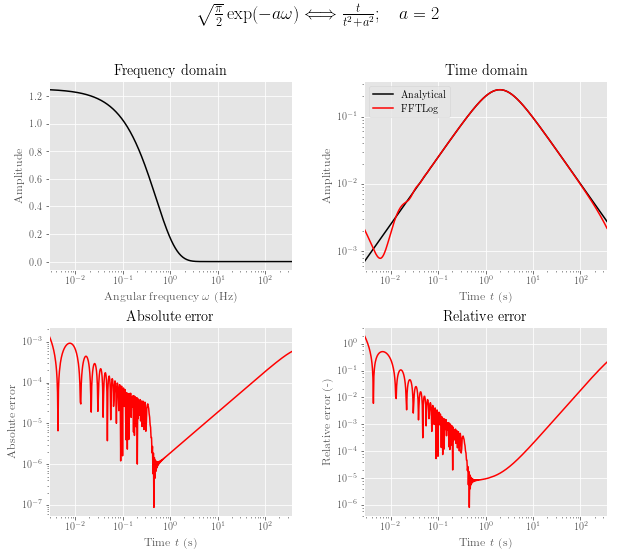

In [4]:
# FFTLog parameters
n, spacing, center = 512, .01, 0
bias = -0.5
transform = 'sine'
w, t, kr, rk = fftpack.fftlogargs(n, spacing, center, transform, bias, kr=1, kropt=True)

# Analytical solution
a=2
fw = np.sqrt(np.pi/2)*np.exp(-a*w)  # Frequency domain
ft = t/(t**2+a**2)         # Time domain
title = r'$\sqrt{\frac{\pi}{2}}\exp(-a\omega) \Longleftrightarrow \frac{t}{t^2 + a^2}; \quad a=2$'

# FFTLog
fftl = fftpack.fftlog(fw, spacing, transform, bias, kr, rk)

print(np.all(np.isclose(fftl[180:-120], ft[180:-120], rtol=1e-3, atol=1e-6)))

# Print result
printfig(w, fw, t, ft, fftl, title)

#### 1.1.3 $\qquad \frac{1}{\sqrt{\omega}} \Longleftrightarrow \frac{1}{\sqrt{t}}$

True


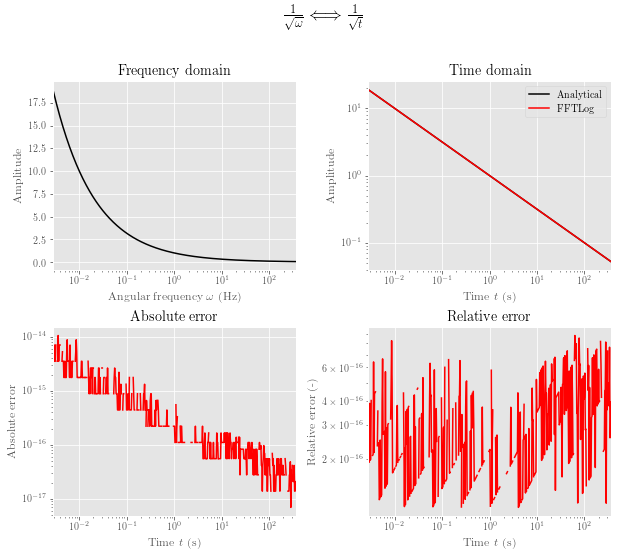

In [5]:
# FFTLog parameters
n, spacing, center = 512, .01, 0
bias = 0
transform = 'sine'
w, t, kr, rk = fftpack.fftlogargs(n, spacing, center, transform, bias, kr=1, kropt=True)

# Analytical solution
fw = np.sqrt(1/w)  # Frequency domain
ft = 1/np.sqrt(t)  # Time domain
title = r'$\frac{1}{\sqrt{\omega}} \Longleftrightarrow \frac{1}{\sqrt{t}}$'

# FFTLog
fftl = fftpack.fftlog(fw, spacing, transform, bias, kr, rk)

print(np.all(np.isclose(fftl, ft)))

# Print result
printfig(w, fw, t, ft, fftl, title)

#### 1.1.4 $\qquad \sqrt{\frac{\pi}{2}} \Longleftrightarrow \frac{1}{t}$

True


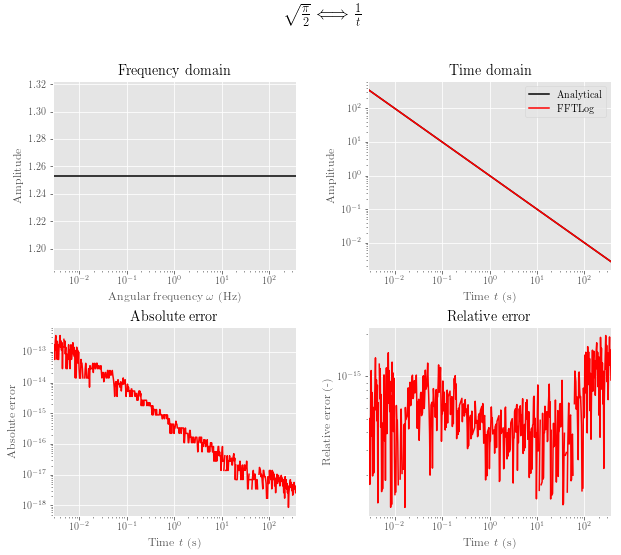

In [6]:
# FFTLog parameters
n, spacing, center = 512, .01, 0
bias = 0.5
transform = 'sine'
w, t, kr, rk = fftpack.fftlogargs(n, spacing, center, transform, bias, kr=1, kropt=True)

# Analytical solution
fw = np.sqrt(np.pi/(2*np.ones(w.size)))  # Frequency domain
ft = 1/t                                 # Time domain
title = r'$\sqrt{\frac{\pi}{2}} \Longleftrightarrow \frac{1}{t}$'

# FFTLog
fftl = fftpack.fftlog(fw, spacing, transform, bias, kr, rk)

print(np.all(np.isclose(fftl, ft)))

# Print result
printfig(w, fw, t, ft, fftl, title)

#### 1.1.5 $\qquad \sqrt{\frac{2}{\pi}}\frac{\omega}{1 + \omega^2} \Longleftrightarrow \exp{-t}$

True


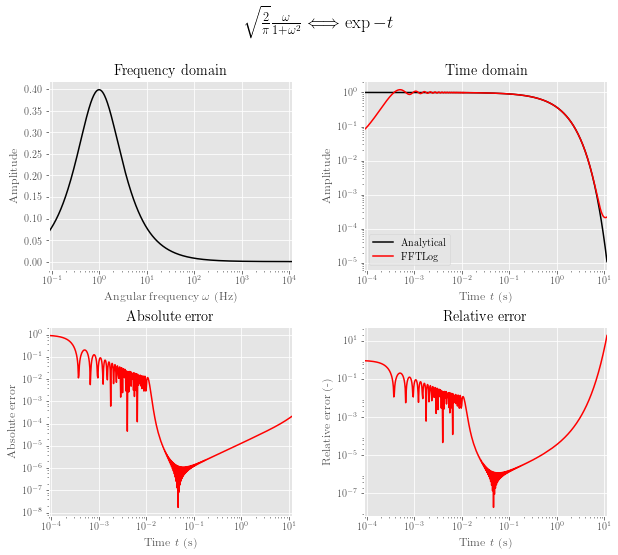

In [7]:
# FFTLog parameters
n, spacing, center = 512, .01, 1.5
bias = 0
transform = 'sine'
w, t, kr, rk = fftpack.fftlogargs(n, spacing, center, transform, bias, kr=1, kropt=True)

# Analytical solution
fw = np.sqrt(2/np.pi)*w/(1 + w**2)  # Frequency domain
ft = np.exp(-t)                                 # Time domain
title = r'$\sqrt{\frac{2}{\pi}}\frac{\omega}{1 + \omega^2} \Longleftrightarrow \exp{-t}$'

# FFTLog
fftl = fftpack.fftlog(fw, spacing, transform, bias, kr, rk)

print(np.all(np.isclose(fftl[220:-60], ft[220:-60], rtol=1e-3, atol=1e-6)))

# Print result
printfig(w, fw, t, ft, fftl, title)

### 1.2 Cosine examples

#### 1.2.1 $\qquad \frac{1}{\sqrt{\omega}} \Longleftrightarrow \frac{1}{\sqrt{t}}$

True


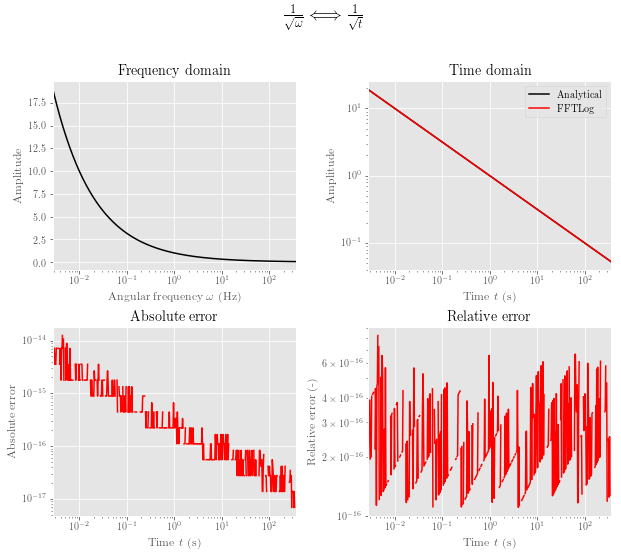

In [8]:
# FFTLog parameters
n, spacing, center = 512, .01, 0
bias = 0
transform = 'cosine'
w, t, kr, rk = fftpack.fftlogargs(n, spacing, center, transform, bias, kr=1, kropt=True)

# Analytical solution
fw = np.sqrt(1/w)  # Frequency domain
ft = 1/np.sqrt(t)  # Time domain
title = r'$\frac{1}{\sqrt{\omega}} \Longleftrightarrow \frac{1}{\sqrt{t}}$'

# FFTLog
fftl = fftpack.fftlog(fw, spacing, transform, bias, kr=kr, rk=rk)

print(np.all(np.isclose(fftl, ft)))

# Print result
printfig(w, fw, t, ft, fftl, title)

## 2. CSEM

Andrew Hamilton created and used FFTLog for astrophysical data, I use it here for controlled-source electromagnetic (CSEM) data, as used for exploration purposes (near-surface, mining, petroleum).

For simple cases, analytical functions exist for frequency- and the time-domain solutions. For more complex model, the solution is generally calculated in the wavenumber-frequency domain, transformed with a Hankel transform to the space-frequency domain, and with an FFT to the space-time domain. It is in this last step where FFTLog comes in handy.

### Analytical solutions for source and receiver at the interface between two half-spaces

The time-domain step and impulse responses for a source at the origin ($x_s = y_s = z_s = 0\,$m) and an in-line receiver at the surface ($y_r = z_r = 0\,$m), is given by the following equations, where $\rho$ is resistivity ($\Omega\,$m), $r$ is offset (m), $t$ is time (s), and $\tau = \sqrt{\mu_0 r^2/(\rho t)}$; $\mu_0$ is the magnetic permeability of free space (H/m).

#### Frequency domain

$$
    \hat{E}_x(\rho,r,s) = \frac{\rho I l}{2 \pi r^3}
    \left[ 1 + (1+\gamma) \exp\left(- \gamma \right)\right], \qquad (\textrm{V/m})
$$

$\gamma = \sqrt{\mu_0 s r^2/\rho}, \qquad (\textrm{-})$,

$s~=~\textrm{i} \omega,\qquad (\textrm{Hz})$


#### Time Domain (Impulse Response)
For causal times $t>0\,$s

$$
    E_x(\rho,r,t) = \frac{\rho \tau^3 I l}{8 t \pi^{3/2} r^3} \exp\left(-\frac{\tau^2}{4}\right),
    \qquad (\textrm{V/(m s)})
$$

$\tau = \sqrt{\mu_0 r^2/(\rho t)}, \qquad (\textrm{-})$,

#### Sine transform

$$
    E(t) = -\frac{2}{\pi}\int^\infty_0 \Im(E(r, \omega))\sin(\omega t)d\omega
$$

#### Analytical functions

In [9]:
from scipy.constants import mu_0
def ex_time(res, off, time):
    """Isotropic half-space impulse response, xx, inline, time domain.
    
    For a 1 A source (I) of 1 m length (dl).

    res   : resistivity [Ohm.m]
    off   : offset [m]
    time  : time(s) [s], causal (time > 0 s)
    """
    tau = np.sqrt(mu_0*off**2/(res*time))
    return res*tau**3/(8*time*np.pi**1.5*off**3)*np.exp(-tau**2/4)

def ex_freq(res, off, omega):
    """Isotropic half-space impulse response, xx, inline, frequency domain.

    For a 1 A source (I) of 1 m length (dl).

    res   : resistivity [Ohm.m]
    off   : offset [m]
    omega : angular requency(ies) [Hz]
    """
    gamma = np.sqrt(mu_0*1j*omega*off**2/res)
    return res/(2*np.pi*off**3)*(1 + (1 + gamma)*np.exp(-gamma))

### 2.1 CSEM example

Source at the origin, receiver at 6 km offset, half-space of $10\,\Omega\,\mathrm{m}$.

The time-range of interest is about $0.1\,\mathrm{s} - 10\,\mathrm{s}$.

The relative error is exploding for smaller and larger times, but because the result is approaching zero.

/home/dtr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/home/dtr/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6457: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


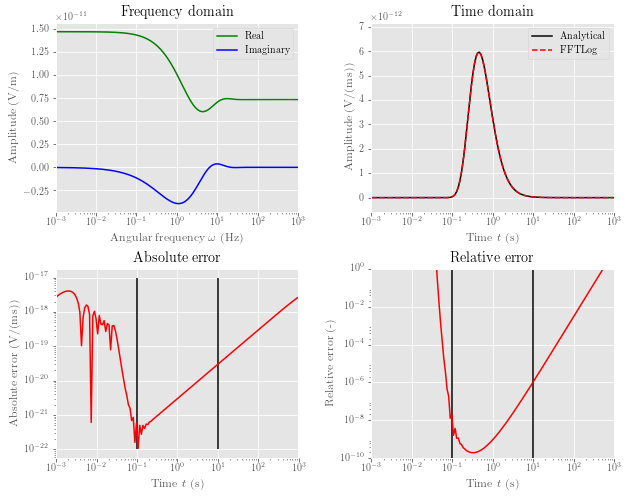

In [10]:
rec = 6000  # Receivers in-line, 0.5m below interface
res = 10    # Resistivity: [air, half-space]

n, spacing,  center = 151, .04, 0
bias = -0.5
transform = 'sine'
w, t, kr, rk = fftpack.fftlogargs(n, spacing, center, transform, bias, kr=1, kropt=True)
rk /= np.pi/2  # Divide by pi/2, because of the definition of the sine transform

# Calculate frequency and time responses
exf = ex_freq(res, rec, w)
ext = ex_time(res, rec, t)

# scipy version
fftl = fftpack.fftlog(-exf.imag, spacing, transform, bias, kr, rk)

# Plot
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=.3, hspace=.3)

plt.subplot(221)
plt.title(r'Frequency domain')
plt.xlabel('Angular frequency $\omega$ (Hz)')
plt.ylabel(r'Amplitude (V/m)')
plt.semilogx(w, exf.real, 'g-', label='Real')
plt.semilogx(w, exf.imag, 'b-', label='Imaginary')
plt.xlim([w.min(), w.max()])
plt.legend(loc='best')

plt.subplot(222)
plt.title(r'Time domain')
plt.xlabel('Time $t$ (s)')
plt.ylabel(r'Amplitude (V/(m\,s))')
plt.plot(t, ext, 'k-', label='Analytical')
plt.plot(t, fftl, 'r--', label='FFTLog')
plt.xscale('log')
plt.xlim([t.min(), t.max()])
plt.ylim([-.1*ext.max(), 1.2*ext.max()])
plt.legend(loc='best')

# Plot the absolute error
plt.subplot(223)
plt.title('Absolute error')
plt.ylabel(r'Absolute error (V/(m\,s))')
plt.xlabel('Time $t$ (s)')
plt.vlines(1e-1, 1e-22, 1e-17)
plt.vlines(1e1, 1e-22, 1e-17)
plt.loglog(t, abs(fftl-ext), 'r-')
plt.xlim([t.min(), t.max()])

# Plot the relative error
plt.subplot(224)
plt.title('Relative error')
plt.ylabel('Relative error (-)')
plt.xlabel('Time $t$ (s)')
plt.vlines(1e-1, 1e-10, 1e0)
plt.vlines(1e1, 1e-10, 1e0)
plt.loglog(t, abs(fftl-ext)/ext, 'r-')
plt.xlim([t.min(), t.max()])
plt.ylim([1e-10, 1e0])

plt.show()